In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

import platform

In [2]:
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f60p02-ch2sk1fk1fl1.jpg'
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f53p02-ch2sk1fk1fl1.tiff'
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f17p02-ch2sk1fk1fl1.tiff'
image_filename = '/Users/carolinemccue/Dropbox (MIT)/Summer 2022/Shear_CHO_61622/10um_1/10um_before_1.tif'

if os.path.isdir(image_filename):
    img_list = [os.path.join(image_filename,f) for f in os.listdir(image_filename) if f.endswith('.jpg')]
elif os.path.isfile(image_filename):
    img_list = [image_filename]

for image_file in img_list:
        image = cv2.imread(image_file, 0)

In [3]:
x = 0
out_directory = "CHO_shear_" + str(x)
while os.path.exists(out_directory):
    x = int(os.path.basename(out_directory).split('_')[1])
    x += 1
    out_directory = "CHO_shear_" + str(x)
os.mkdir("CHO_shear_" + str(x))

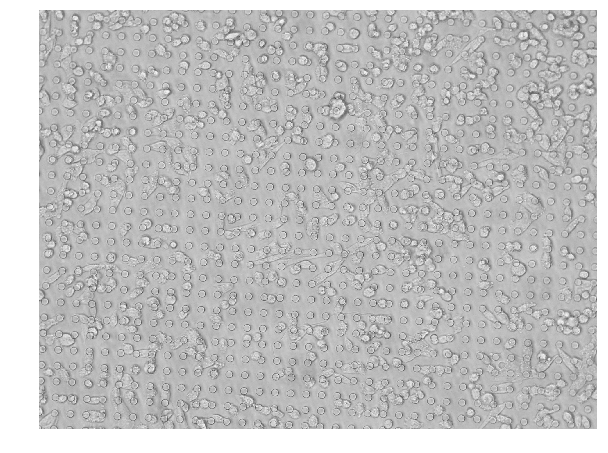

In [4]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

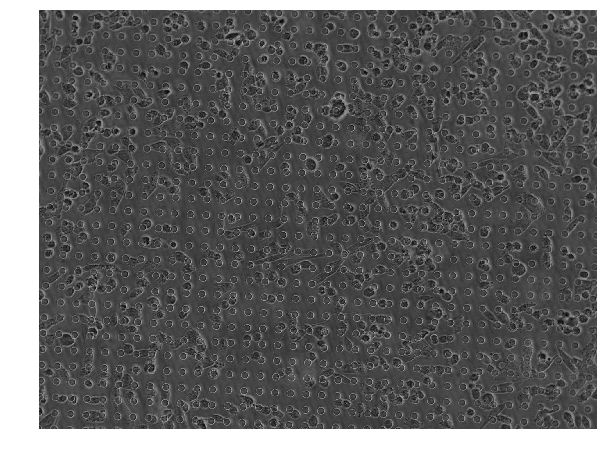

In [5]:
image = np.invert(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

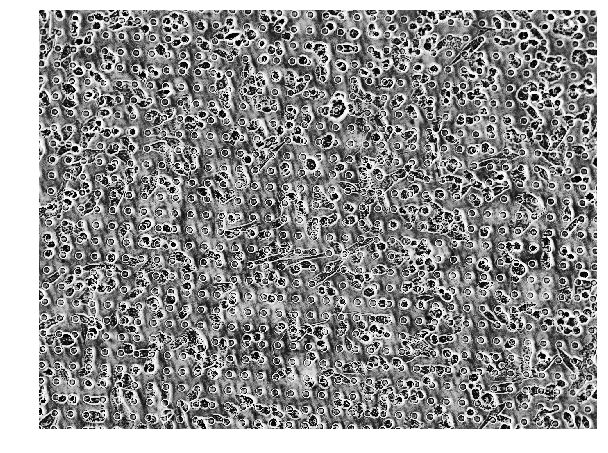

In [20]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(10,10))
img_adapteq = clahe.apply(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')

Minimum threshold: 70.0
Min intensity: 0
Max intensity: 255


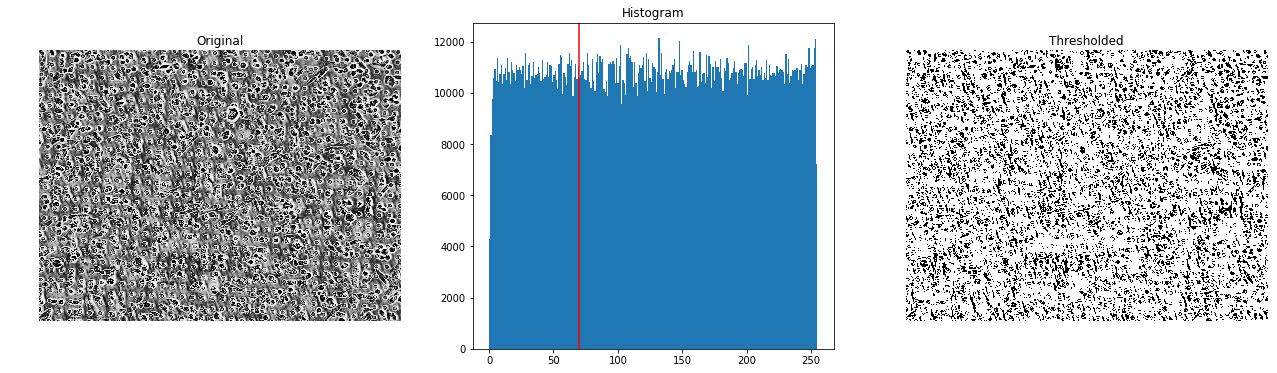

In [21]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,70,255,cv2.THRESH_BINARY)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

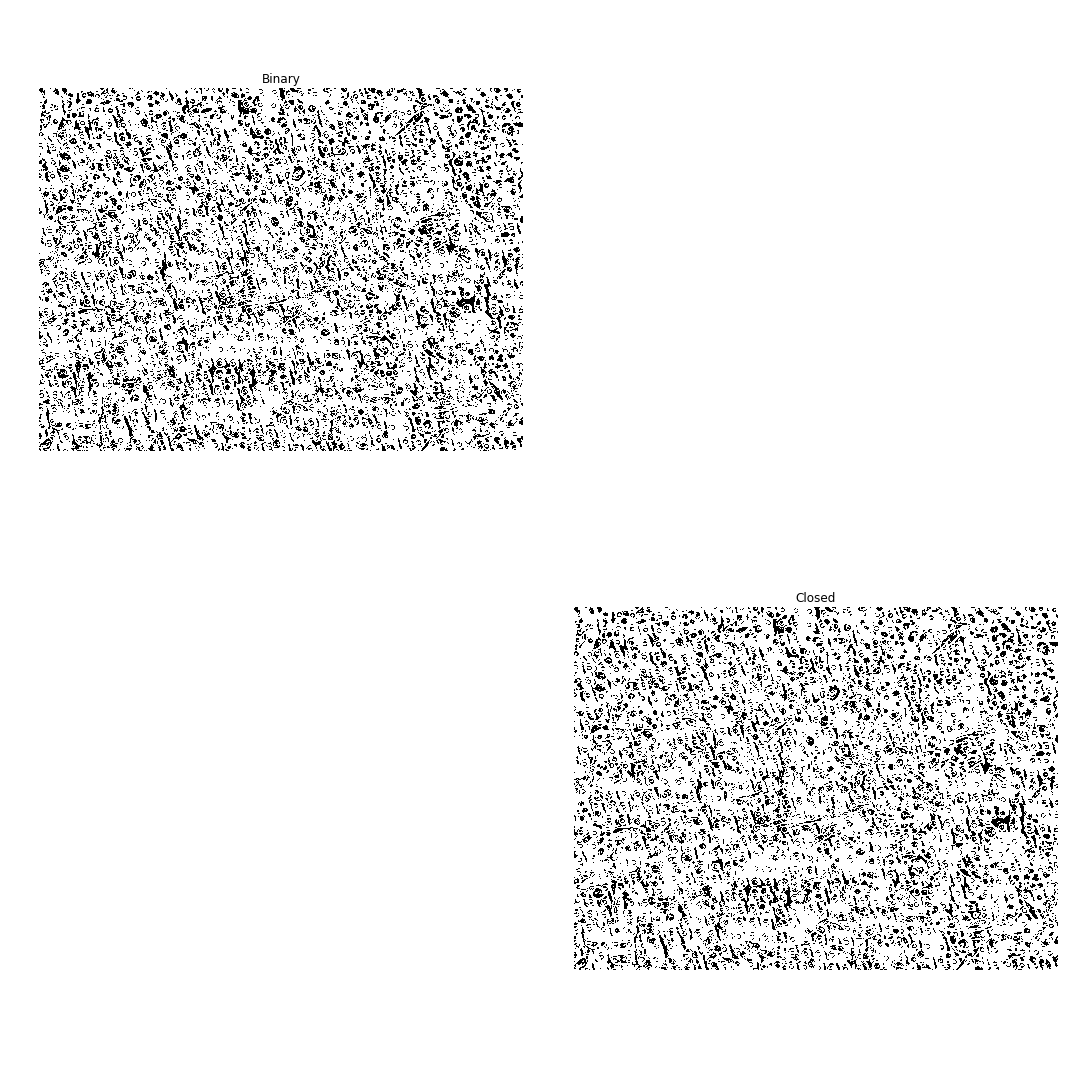

In [22]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 20)
#remove_posts = morphology.remove_small_holes(remove_posts, 20)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

In [23]:
closed=np.invert(closed)

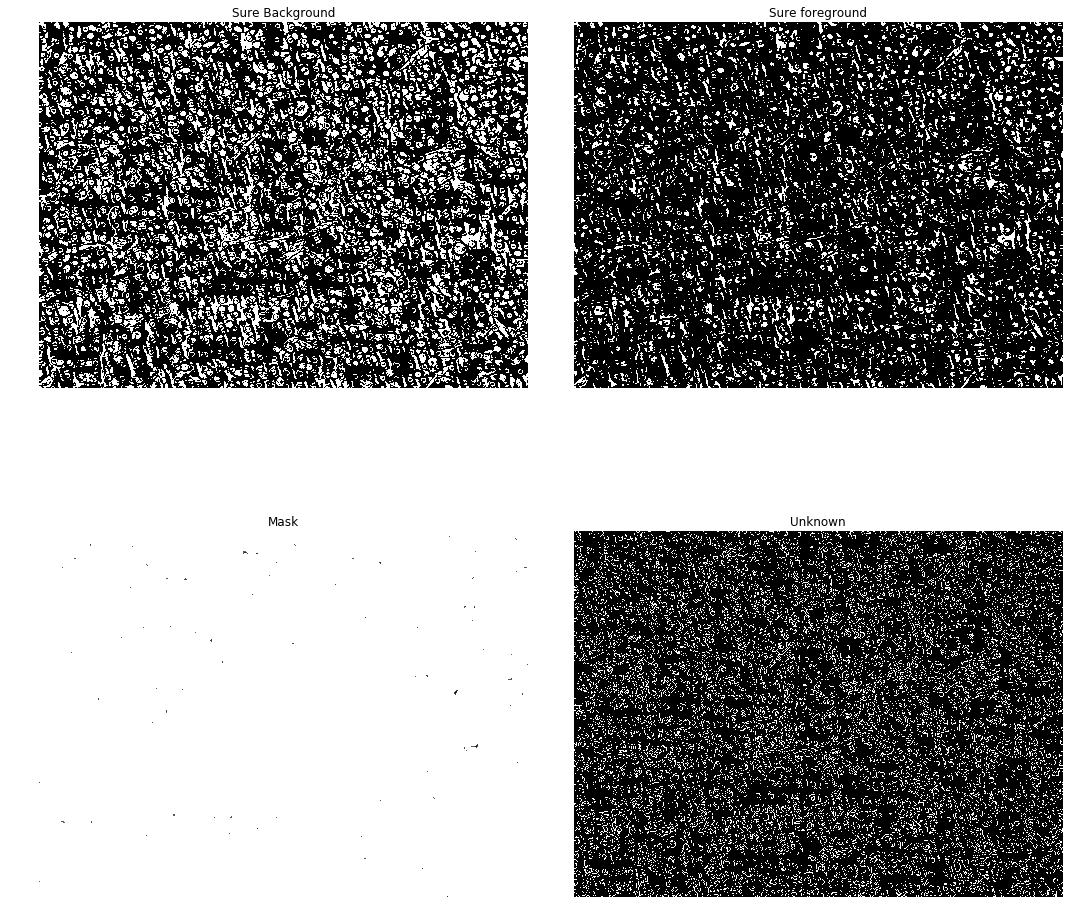

In [24]:
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

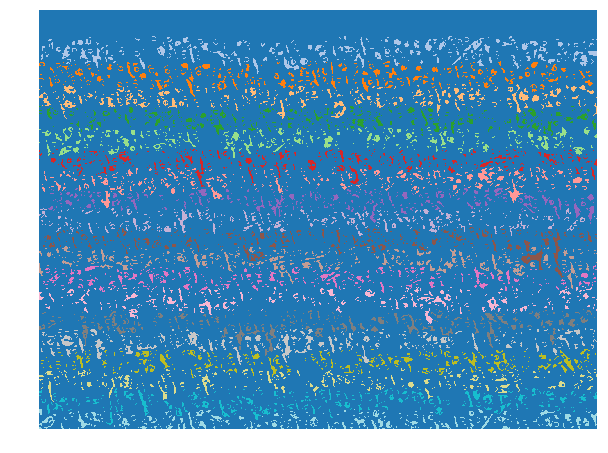

In [25]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1
markers[unknown>0] = 0

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(markers, cmap=plt.cm.tab20)

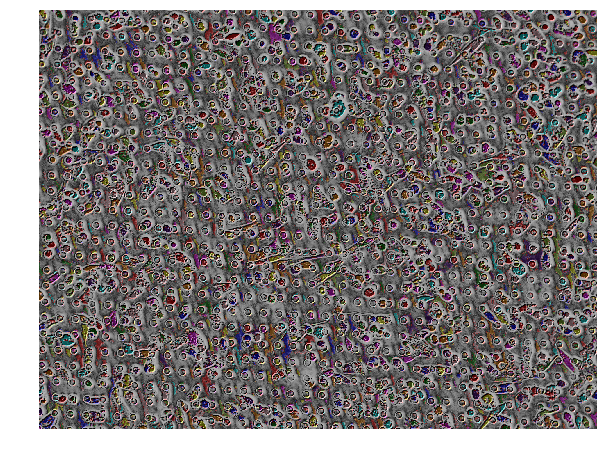

In [26]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image, bg_label=1)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image_label_overlay)

In [27]:
reg = regionprops(segmented, intensity_image=image)[1:]
cellreg = [region for region in reg if (region.area) > 100 and (region.area) < 25000]
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg])
df.head(5)

Label   Area  Eccentricity  Circularity  Bbox Area               Bbox  \
0    2.0  366.0      0.827143     0.376692  2764800.0     (1, 1, 32, 27)   
1    4.0  357.0      0.816945     0.379607  2764800.0    (1, 61, 30, 83)   
2    5.0  333.0      0.690693     0.690624  2764800.0   (1, 95, 27, 116)   
3   13.0  114.0      0.968925     0.411950  2764800.0  (1, 640, 25, 651)   
4   16.0  204.0      0.364638     0.385690  2764800.0  (1, 713, 17, 731)   

                                   Centroid  \
0   (13.09016393442623, 13.904371584699453)   
1   (16.361344537815125, 71.86834733893558)   
2  (10.924924924924925, 104.32132132132132)   
3    (9.850877192982455, 645.7280701754386)   
4               (8.058823529411764, 721.25)   

                                               Image  Long Axis  Short Axis  
0  [[0, 0, 0, 0, 0, 0, 0, 8, 10, 10, 11, 10, 17, ...  33.160237   18.635763  
1  [[0, 0, 0, 0, 31, 36, 60, 117, 56, 0, 0, 0, 0,...  30.237231   17.438295  
2  [[43, 47, 40, 29, 40, 43, 40, 47, 66, 60, 47, ...  25.183316   18.211262  
3  [[36, 32, 35, 55, 43, 48, 70, 60, 141, 0, 0], ...  29.236835    7.231882  
4  [[0, 47, 32, 34, 38, 47, 67, 52, 108, 97, 69, ...  19.607193   18.257222

In [28]:
df['Area'].median(), df['Area'].mean()

(214.0, 278.0655375552283)

1358 cells were detected and segmented
669 cells with selected criteria


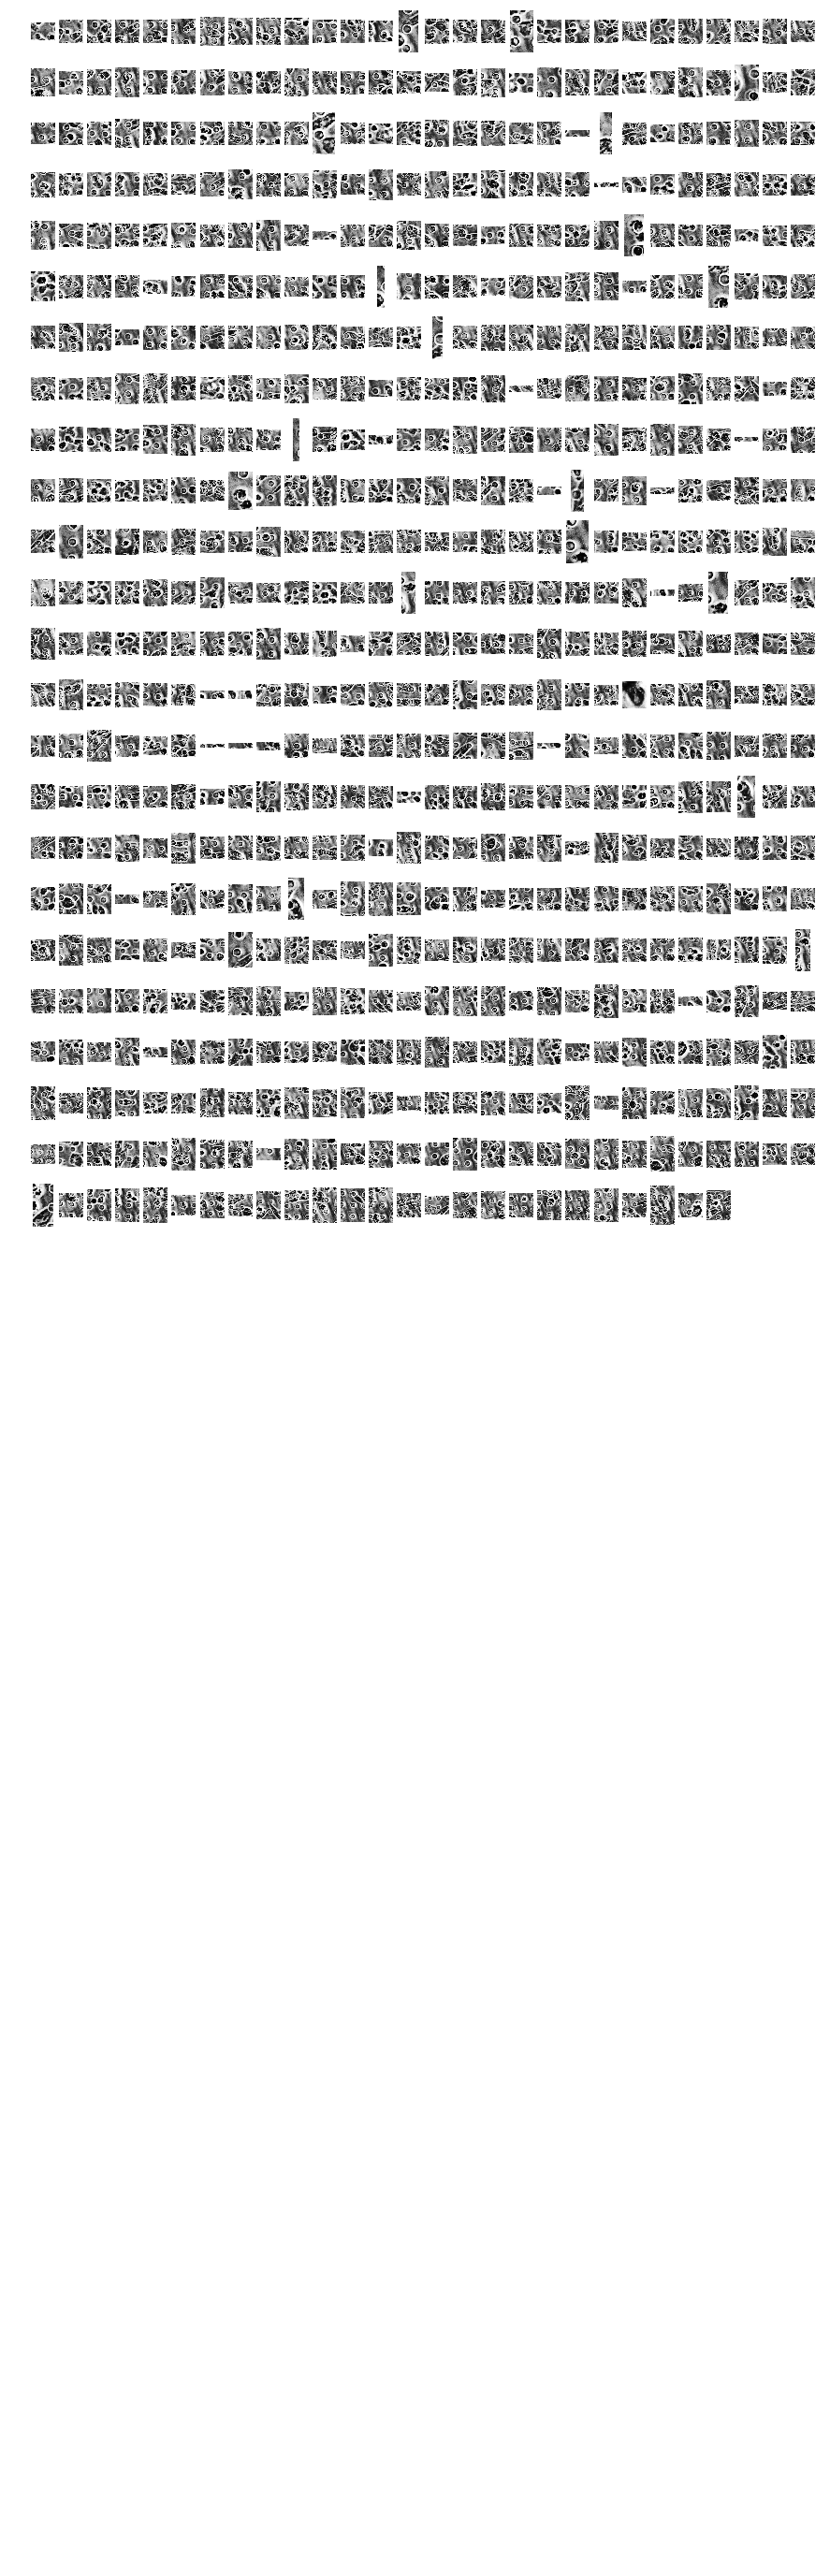

In [29]:
# Display parameters
org_img = image # Intensity image
border = 75 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.05 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 1
area_cutoff_upper = 5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 1*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(cellreg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

cellreg.sort(key=lambda x: x.area)
cellreg_clean = [region for region in cellreg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(cellreg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(cellreg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
    imsave(name, contrast_stretch, check_contrast=False)
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(cellreg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)

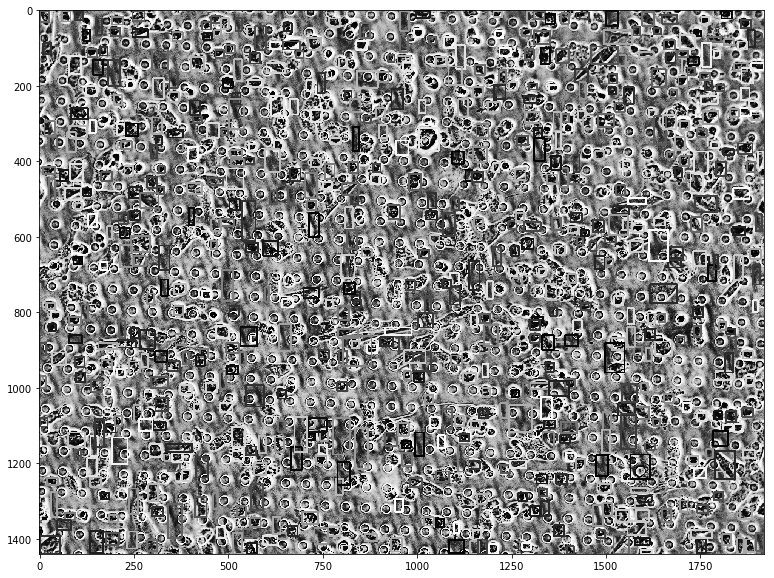

In [16]:
boxed_regions = image.copy()
for region in cellreg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    #cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [17]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg_clean])
df2.tail(5)

Label    Area  Eccentricity  Circularity  Bbox Area  \
624  1935.0  1070.0      0.970719     0.136153  2764800.0   
625  1127.0  1197.0      0.750892     0.149960  2764800.0   
626  4491.0  1219.0      0.935810     0.109295  2764800.0   
627  2275.0  1227.0      0.831150     0.193450  2764800.0   
628  4598.0  1309.0      0.968763     0.200743  2764800.0   

                       Bbox                                 Centroid  \
624    (504, 538, 610, 573)   (556.3869158878505, 556.2803738317757)   
625  (313, 1006, 373, 1058)  (341.1144527986633, 1033.9757727652463)   
626  (1080, 777, 1176, 823)  (1123.1985233798196, 798.0779327317473)   
627  (581, 1614, 665, 1666)  (629.9543602281989, 1636.2428687856561)   
628  (1107, 837, 1214, 870)   (1158.5614973262032, 851.488922841864)   

                                                 Image   Long Axis  Short Axis  
624  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  103.213656   24.793847  
625  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   70.449280   46.526481  
626  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   98.837804   34.840804  
627  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, ...   68.333468   37.996720  
628  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  101.274514   25.114742

In [18]:
areaum10 = df2['Area'] / 1.5503 ** 2
celllength10 = df2['Long Axis'] / 1.5503
circularity10 = df2['Circularity']
aspectratio10 = df2['Short Axis']/df2['Long Axis']
areaum10.mean(), areaum10.std()

(157.03113483571371, 71.75604652200815)

In [19]:
%store areaum10
%store circularity10
%store celllength10
%store aspectratio10

Stored 'areaum10' (Series)
Stored 'circularity10' (Series)
Stored 'celllength10' (Series)
Stored 'aspectratio10' (Series)
